In [ ]:
import tensorflow as tf
import keras
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import os
import datetime
import pandas as pd
from pathlib import Path
from numpy.typing import NDArray

tf.config.list_physical_devices('GPU')

2025-03-16 21:09:48.940795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742184588.958505   40665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742184588.964030   40665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 21:09:48.981744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gkouretas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data: NDArray = np.load("training_datasets.npy", allow_pickle=True)
labels: NDArray = np.load("training_labels.npy", allow_pickle=True)

In [3]:
data.shape, labels.shape

((34, 6, 4), (34, 6))

## Configuration values

In [ ]:
baseline_config = {
    "LSTM_KWARGS": {
        "units": 32, 
        "dropout": 0.25, 
        "return_sequences": True
    },
    "CONV_KWARGS": [
        {"filters": 256, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
        {"filters": 128, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
        {"filters": 64, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"}
    ],
    "CUSTOM_WEIGHTS": None,
    "WINDOW_SIZE_SEC": 5.0,
    "STRIDE_SEC": 1.0,
    "MAX_PREDICTED_LENGTH_SEC": 120.0,
    "OPTIMIZER": keras.optimizers.Adam
}

In [ ]:
higher_window_config = copy.deepcopy(baseline_config)
higher_window_config["WINDOW_SIZE_SEC"] = 10.0

lower_window_config = copy.deepcopy(baseline_config)
lower_window_config["WINDOW_SIZE_SEC"] = 2.5

higher_stride_config = copy.deepcopy(baseline_config)
higher_stride_config["STRIDE_SEC"] = 2.5

lower_stride_config = copy.deepcopy(baseline_config)
lower_stride_config["STRIDE_SEC"] = 0.5

no_conv_config = copy.deepcopy(baseline_config)
no_conv_config["CONV_KWARGS"] = None

higher_lstm_units = copy.deepcopy(baseline_config)
higher_lstm_units["LSTM_KWARGS"]["units"] = 256

custom_weights_config = copy.deepcopy(baseline_config)
custom_weights_config["CUSTOM_WEIGHTS"] = {
    "EMG": 0.25,
    "PPG": 0.25,
    "Accelerometer": 0.25,
    "Gyroscope": 0.25
}

no_emg_config = copy.deepcopy(baseline_config)
no_emg_config["CUSTOM_WEIGHTS"] = {
    "EMG": 0.0,
    "PPG": 1/3,
    "Accelerometer": 1/3,
    "Gyroscope": 1/3
}

no_ppg_config = copy.deepcopy(baseline_config)
no_ppg_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "PPG": 0.0,
    "Accelerometer": 1/3,
    "Gyroscope": 1/3
}

no_accel_config = copy.deepcopy(baseline_config)
no_accel_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "PPG": 1/3,
    "Accelerometer": 0.0,
    "Gyroscope": 1/3
}

no_gyro_config = copy.deepcopy(baseline_config)
no_gyro_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "PPG": 1/3,
    "Accelerometer": 0.0,
    "Gyroscope": 1/3
}

In [ ]:
model_configs = [
    baseline_config,
    higher_window_config,
    lower_window_config,
    higher_stride_config,
    lower_stride_config,
    no_conv_config,
    higher_lstm_units,
    custom_weights_config,
    no_emg_config,
    no_ppg_config,
    no_accel_config,
    no_gyro_config
]

In [ ]:
MASK_VALUE = 0.0
N_EPOCHS = 5

In [5]:
SAMPLING_RATE_EMG = 1. / 1000
SAMPLING_RATE_BPM = 1. / 200
SAMPLING_RATE_IMU = 1. / 100

(98640,) 98.64
(19727,) 98.635
(9864,) 98.64
(9864,) 98.64
(98000,) 98.0
(58570,) 58.57
(11713,) 58.565
(5857,) 58.57
(5857,) 58.57
(57000,) 57.0


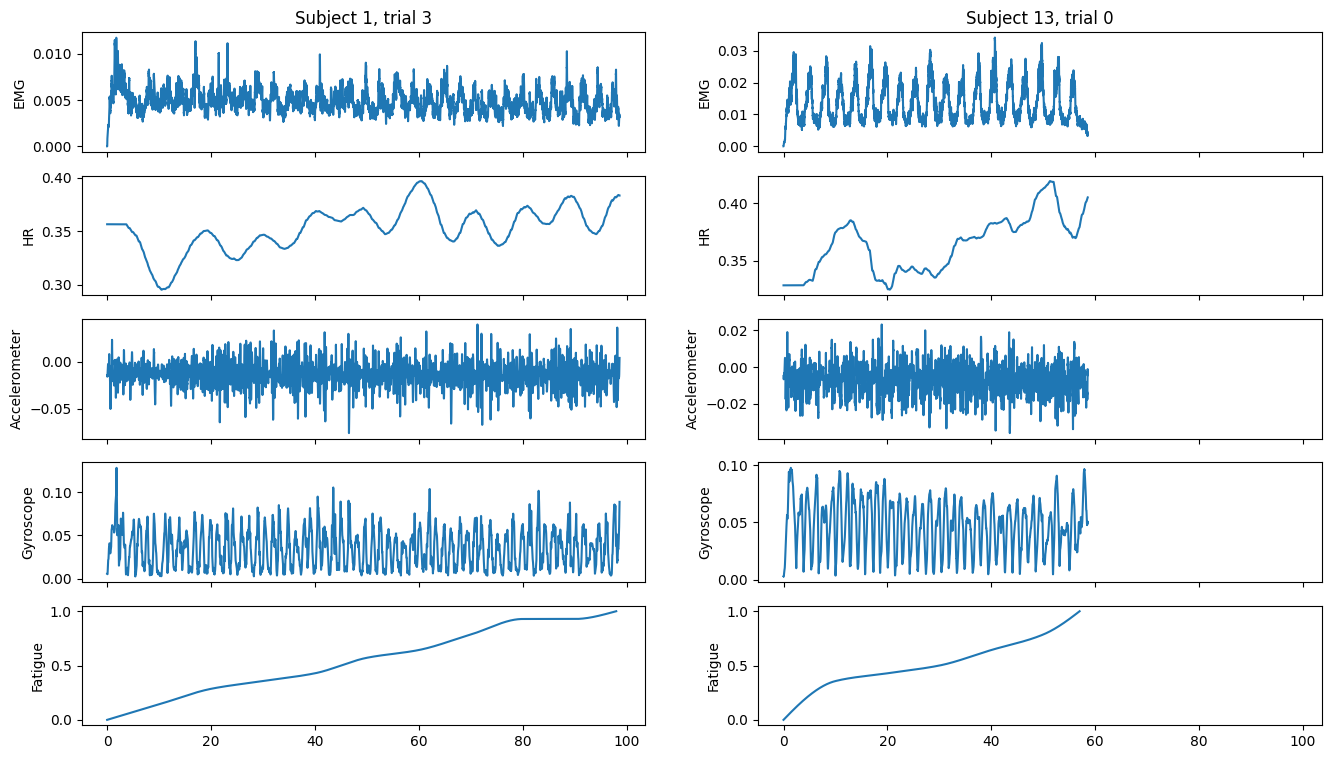

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

n_images = 2
fig, ax = plt.subplots(len(signals), n_images, sharex=True, figsize=(16,9))

for i in range(n_images):
    subject = np.random.randint(0, data.shape[0])
    trial = np.random.randint(0, data.shape[1])

    ax[0][i].set_title(f"Subject {subject}, trial {trial}")

    for j in range(len(signals)):
        if j == len(signals)-1:
            signal: NDArray = labels[subject][trial]
        else:
            signal: NDArray = data[subject][trial][j]

        print(signal.shape, sampling_rates[j]*signal.size)

        ax[j][i].plot(
            np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
            signal
        )

        ax[j][i].set_ylabel(signals[j])

In [ ]:
from fatigue_classifier.fatigue_classifier.fatigue_model import FatigueClassifier
from fatigue_classifier.fatigue_classifier.fatigue_block import FatigueLSTMBlock

In [8]:
data.shape

(34, 6, 4)

In [9]:
combined_data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
combined_data.shape

(204, 4)

In [10]:
labels.shape

(34, 6)

In [11]:
combined_labels = labels.reshape((labels.shape[0]*labels.shape[1],))
combined_labels.shape

(204,)

In [ ]:
def init_model(config: dict):
    lstm_blocks = []
    shapes = []

    inputs = {}

    for i, Ts in enumerate(sampling_rates[:-1]):
        inputs[signals[i]] = FatigueClassifier.preprocess_signal(
            combined_data[..., i], 
            fs=1/Ts, 
            window_size=config["WINDOW_SIZE_SEC"], 
            stride=config["STRIDE_SEC"], 
            max_duration_sec=config["MAX_PREDICTED_LENGTH_SEC"], 
            pad_value=MASK_VALUE
        )

    outputs = FatigueClassifier.preprocess_labels(
        combined_labels, 
        fs=1000, 
        window_size=config["WINDOW_SIZE_SEC"], 
        stride=config["STRIDE_SEC"], 
        max_duration_sec=config["MAX_PREDICTED_LENGTH_SEC"], 
        pad_value=MASK_VALUE
    )

    for k, v in inputs.items():
        if not config["CUSTOM_WEIGHTS"]: 
            weight = None
        elif k == "EMG": 
            weight = config["CUSTOM_WEIGHTS"]["EMG"]
        elif k == "HR": 
            weight = config["CUSTOM_WEIGHTS"]["HR"]
        elif k == "Accelerometer": 
            weight = config["CUSTOM_WEIGHTS"]["Accelerometer"]
        elif k == "Gyroscope": 
            weight = config["CUSTOM_WEIGHTS"]["Gyroscope"]
        else: 
            raise NotImplementedError(f"Invalid key: {k}")

        lstm_block = FatigueLSTMBlock(
            weight=weight, 
            mask=MASK_VALUE, 
            lstm_kwargs=config["LSTM_KWARGS"], 
            conv_layers_kwargs=config["CONV_KWARGS"]
        )

        lstm_blocks.append(lstm_block)

        # Insert "None" as the first element to represent the batch size 
        shapes.append(tuple([None] + list(v.shape[1:])))

    fatigue_classifier = FatigueClassifier(lstm_blocks=lstm_blocks)
    fatigue_classifier.build(shapes)
    print(fatigue_classifier.summary(expand_nested=True))

    fatigue_classifier.compile(optimizer=baseline_config["OPTIMIZER"](), loss=fatigue_classifier.model_loss_function)

    return fatigue_classifier, inputs, outputs

Input shape: $ (N_B, N_T, N_S) $

Where

$N_B = $ batch size,

$N_T = $ timesteps,

$N_S = $ samples

Output shape: $ (N_B, N_T) $

Where

$N_B = $ batch size

$N_T = $ timesteps

In [ ]:
VALIDATION_SPLIT = 0.8

In [ ]:
%matplotlib inline
def plot_images(output_path: Path, model: FatigueClassifier, config: dict, training_dataset: tf.data.Dataset, validation_dataset: tf.data.Dataset, source_signals: NDArray, source_labels: NDArray):
    os.makedirs(os.path.join(output_path, "train"), exist_ok=True)
    os.makedirs(os.path.join(output_path, "validation"), exist_ok=True)

    signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
    sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    train_losses = []
    validation_losses = []

    offset = int(VALIDATION_SPLIT * source_signals.shape[0])

    for i, inputs, outputs in enumerate(training_dataset.as_numpy_iterator()):
        ax.set_title(f"Training dataset (index={i})")

        for j,name in enumerate(signals):
            if name != "Fatigue":
                signal: NDArray = combined_data[i][j]
            else:
                signal: NDArray = combined_labels[i]

            signal=signal[np.where(signal != MASK_VALUE)]

            ax.plot(
                np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
                signal
            )

            ax.set_ylabel(signals[j])

            if name == "Fatigue":
                out = model.predict(
                    inputs,
                    batch_size=1
                )

                out_pred = copy.deepcopy(out[0, :, 0])
                out_pred=out_pred[np.where(outputs[i] != MASK_VALUE)]

                ax.scatter(
                    np.arange(config["WINDOW_SIZE_SEC"], config["WINDOW_SIZE_SEC"]+out_pred.size*config["STRIDE_SEC"], config["STRIDE_SEC"]), 
                    out_pred,
                    c="red"
                )

                loss = FatigueClassifier.loss(tf.convert_to_tensor(outputs[i].reshape((1, outputs[i].shape[0], 1)), dtype=tf.float32), out, MASK_VALUE)
                train_losses.append(loss)
                ax.text(0.0, 0.8, f"MSE: {loss:.4f}", 
                    fontsize=12, ha='left', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

        fig.savefig(os.path.join(output_path, "train", f"train_{i}.png"))

    for i, inputs, outputs in enumerate(validation_dataset.as_numpy_iterator()):
        ax.set_title(f"Validation dataset (index={i})")

        for j,name in enumerate(signals):
            if name != "Fatigue":
                signal: NDArray = combined_data[i+offset][j]
            else:
                signal: NDArray = combined_labels[i+offset]

            signal=signal[np.where(signal != MASK_VALUE)]

            ax.plot(
                np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
                signal
            )

            ax.set_ylabel(signals[j])

            if name == "Fatigue":
                out = model.predict(
                    inputs,
                    batch_size=1
                )

                out_pred = copy.deepcopy(out[0, :, 0])
                out_pred=out_pred[np.where(outputs[i+offset] != MASK_VALUE)]

                ax.scatter(
                    np.arange(config["WINDOW_SIZE_SEC"], config["WINDOW_SIZE_SEC"]+out_pred.size*config["STRIDE_SEC"], config["STRIDE_SEC"]), 
                    out_pred,
                    c="red"
                )

                loss = FatigueClassifier.loss(tf.convert_to_tensor(outputs[i+offset].reshape((1, outputs[i+offset].shape[0], 1)), dtype=tf.float32), out, MASK_VALUE)
                validation_losses.append(loss)
                ax.text(0.0, 0.8, f"MSE: {loss:.4f}", 
                    fontsize=12, ha='left', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
                
        fig.savefig(os.path.join(output_path, "validation", f"validation_{i}.png"))

    return train_losses, validation_losses

In [ ]:
np.random.seed(42)
output_path = f"fatigue_ml_outputs_{datetime.datetime.now().isoformat()}"

for config in model_configs:
    fatigue_classifier, inputs, outputs = init_model(config)
    N_SAMPLES = inputs["EMG"].shape[0]

    indices = np.random.shuffle(np.arange(N_SAMPLES))
    
    full_dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(
        ((
            tf.convert_to_tensor(inputs["EMG"][indices], dtype="float32"), 
            tf.convert_to_tensor(inputs["HR"][indices], dtype="float32"), 
            tf.convert_to_tensor(inputs["Accelerometer"][indices], dtype="float32"), 
            tf.convert_to_tensor(inputs["Gyroscope"][indices], dtype="float32")
        ), tf.convert_to_tensor(outputs[indices], dtype="float32")) 
    )

    train_dataset = full_dataset.take(int(VALIDATION_SPLIT * N_SAMPLES))
    validation_dataset = full_dataset.skip(int(VALIDATION_SPLIT * N_SAMPLES))
    history = fatigue_classifier.fit(
        train_dataset, 
        batch_size=1, 
        epochs=N_EPOCHS,
        validation_data=validation_dataset
    )

    train_losses, validation_losses = plot_images(
        fatigue_classifier, 
        config, 
        train_dataset, 
        validation_dataset,
        source_signals=combined_data[indices],
        source_labels=combined_labels[indices]
    )

    fatigue_classifier.save(os.path.join(output_path, "fatigue_model.png"))

    # Plot history
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(history.history["loss"])
    ax.plot(history.history["val_loss"])
    ax.set_axisbelow(True)

    fig.savefig(os.path.join(output_path, "loss.png"))

    df = pd.DataFrame()
    df["loss"] = history.history["loss"]
    df["val_loss"] = history.history["val_loss"]
    df.to_csv(os.path.join(output_path, "losses_by_epoch.csv"))

    df = pd.DataFrame()
    df["loss"] = train_losses
    df.to_csv(os.path.join(output_path, "training_losses_by_trial.csv"))

    df = pd.DataFrame()
    df["loss"] = validation_losses
    df.to_csv(os.path.join(output_path, "validation_losses_by_trial.csv"))

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0025

KeyboardInterrupt: 